# Lab 2
+ ## Автор: Роман Кривохижа
+ ## Група: ІС-72
+ ## Викладач: Новікова П.А.

****
****
****

## Module importing

In [64]:
import numpy as np
import pandas as pd

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
sns.set_style('darkgrid')
%matplotlib inline

## Algorithm implementation

+ Алгоритм, який відтворює функціонування системи, за допомогою комп’ютерної програми називається **алгоритмом імітації**.

<font size="4">Ймовірність відмови: $P = \frac{N_{unserv}}{N_{all}}$</font>

<font size="4">Середня довжина черги: $L_{aver} = \frac{\sum_{i} L_i \Delta t_i}{T_{mod}}$</font>

<font size="4">Середній час очікування: $Q_{aver} = \frac{\sum_{i} L_i \Delta t_i}{N_{serv}}$</font>

In [67]:
class Rand:
    """
    Генерація випадкового числа за заданим законом розподілу
    """
    @staticmethod
    def exp(time_mean):
        a = 0
        while a == 0:
            a = np.random.rand()
        return -time_mean * np.log(a)

In [68]:
class Model:
    def __init__(self, delay0, delay1, maxQ=0, print_logs=False):
        """
        :param delay0: mean delay of create
        :param delay1: mean delay of process
        :param maxQ: max size of queue
        :type delay0: float
        :type delay1: float
        :type maxQ: int
        """
        self.delay_create = delay0
        self.delay_process = delay1
        # момент найближчої події
        self.tnext = 0.0
        # конкретний час
        self.tcurr = self.tnext
        # час завершення створення
        self.t0 = self.tcurr
        # час завершення обробки
        self.t1 = np.inf
        # max size of queue
        self.maxqueue = maxQ
        # number of created tasks
        self.num_create = 0
        # number of processed tasks
        self.num_process = 0
        # number of failure tasks
        self.failure = 0
        # current state
        self.state = 0
        # current size of queue
        self.queue = 0
        # ind of next event
        self.next_event = 0
        
        self.delta_t_history = []
        self.queue_history = []
        self.print_logs = print_logs
        
    def simulate(self, time_modeling):
        self.time_modeling = time_modeling
        while self.tcurr < self.time_modeling:
            self.tnext = self.t0
            self.next_event = 0
            
            # знайти найменший із моментів часу «момент надходження вимоги у систему»
            # та «момент звільнення пристрою обслуговування» і запам’ятати,
            # якій події  він відповідає
            if self.t1 < self.tnext:
                self.tnext = self.t1
                self.next_event = 1
            
            # просунути поточний час у момент найближчої події
            self.tcurr = self.tnext
            
            # виконати подію, яка відповідає моменту найближчої події
            if self.next_event == 0:
                self.event0()
            elif self.next_event == 1:
                self.event1()
            else:
                pass
            self.delta_t_history.append(self.tcurr)
            self.queue_history.append(self.queue)
            
            if self.print_logs:
                self.print_info()
        self.print_statistic()
        self.print_L_aver()
        self.print_Q_aver()
        self.print_p_fail()
        
    def print_statistic(self):
        """
        Відображення основних статистик
        """
        print(f'num_create = {self.num_create}; num_process = {self.num_process}; failure = {self.failure}')
        
    def print_info(self):
        """
        Відображення детальної інформації про кожен етап роботи моделі
        """
        print(f't = {self.tcurr}; state = {self.state}; queue = {self.queue}')
        
    def print_L_aver(self):
        """
        Середня довжина черги черги
        """
        t = [self.delta_t_history[0]]
        for i in range(0, len(self.delta_t_history)-1):
             t.append(self.delta_t_history[i+1] - self.delta_t_history[i])
            
        self.l_aver = np.sum(np.array(t) * np.array(self.queue_history)) / self.time_modeling
        print(f'Середня довжина черги черги = {self.l_aver}')
        
    def print_Q_aver(self):
        """
        Середній час очікування в черзі
        """
        t = [self.delta_t_history[0]]
        for i in range(0, len(self.delta_t_history)-1):
             t.append(self.delta_t_history[i+1] - self.delta_t_history[i])
            
        self.q_aver = np.sum(np.array(t) * np.array(self.queue_history)) / self.num_process
        print(f'Середній час очікування в черзі = {self.q_aver}')
    
    def print_p_fail(self):
        """
        Ймовірність відмови
        """
        self.p_fail = self.failure / self.num_create
        print(f'Ймовірність відмови: {self.p_fail}')
    
    def event0(self):
        # подія "натходження"
        self.t0 = self.tcurr + self.__get_delay_of_create()
        self.num_create += 1
        
        # якщо пристрій вільний, тоді встановлюємо стан "зайнятий"
        if self.state == 0:
            self.state = 1
            # запам'ятаємо час виходу
            self.t1 = self.tcurr + self.__get_delay_of_process()
        else:
            if self.queue < self.maxqueue:
                self.queue += 1
            else:
                self.failure += 1
                
    def event1(self):
        # подія "закінчилось обслуговування в пристрої"
        self.t1 = np.inf
        # стан "вільний"
        self.state = 0
        # якщо черга вимог не пуста, перемістити одну вимогу із черги у канал обслуговування
        if self.queue > 0:
            self.queue -= 1
            # стан "зайнятий"
            self.state = 1
            # запам'ятаємо час виходу
            self.t1 = self.tcurr + self.__get_delay_of_process()
        self.num_process += 1
        
    def __get_delay_of_create(self):
        return Rand.exp(self.delay_create)
    
    def __get_delay_of_process(self):
        return Rand.exp(self.delay_process)

In [69]:
model = Model(1, 3, 5, print_logs=True)
model.simulate(10)

t = 0.0; state = 1; queue = 0
t = 1.765636097692804; state = 1; queue = 1
t = 2.799923884841094; state = 1; queue = 0
t = 3.706583932089599; state = 1; queue = 1
t = 4.697707050006574; state = 1; queue = 2
t = 7.243897795446555; state = 1; queue = 1
t = 7.559975824484018; state = 1; queue = 0
t = 8.637960855552107; state = 0; queue = 0
t = 9.001747418993773; state = 1; queue = 0
t = 12.11789685605814; state = 1; queue = 1
num_create = 6; num_process = 4; failure = 0
Середня довжина черги черги = 1.0316882563279608
Середній час очікування в черзі = 2.579220640819902
Ймовірність відмови: 0.0


In [70]:
n_param = 10

delay0_list = list(range(1, n_param+1))
delay1_list = list(range(1, n_param+1))
maxQ_list = list(range(1, n_param+1))

time_modeling_list = [i*1000 for i in range(1, n_param+1)]

np.random.shuffle(delay0_list)
np.random.shuffle(delay1_list)
np.random.shuffle(maxQ_list)
np.random.shuffle(time_modeling_list)

df = pd.DataFrame()
rows = []

for i in range(n_param):
    print(f'{i+1} itteration')
    model = Model(delay0_list[i], delay1_list[i], maxQ_list[i], print_logs=False)
    model.simulate(time_modeling_list[i])
    rows.append({'delay_create': delay0_list[i], 'delay_process': delay1_list[i], 'maxqueue': maxQ_list[i], 'time_modeling': model.time_modeling, 
                 'num_create': model.num_create, 'num_process': model.num_process, 'failure': model.failure, 'last_queue_cnt': model.queue,
                 'l_aver': model.l_aver, 'q_aver': model.q_aver, 'p_fail': model.p_fail})
    print()
df = df.append(rows)

1 itteration
num_create = 856; num_process = 855; failure = 1
Середня довжина черги черги = 0.15884746966489832
Середній час очікування в черзі = 0.9289325711397564
Ймовірність відмови: 0.0011682242990654205

2 itteration
num_create = 1987; num_process = 769; failure = 1211
Середня довжина черги черги = 6.319680557575348
Середній час очікування в черзі = 32.87220055955968
Ймовірність відмови: 0.6094614997483644

3 itteration
num_create = 763; num_process = 744; failure = 17
Середня довжина черги черги = 0.11316080397393366
Середній час очікування в черзі = 1.06468498362572
Ймовірність відмови: 0.022280471821756225

4 itteration
num_create = 1519; num_process = 616; failure = 893
Середня довжина черги черги = 9.295363980860001
Середній час очікування в черзі = 90.53925955383117
Ймовірність відмови: 0.5878867676102699

5 itteration
num_create = 400; num_process = 260; failure = 139
Середня довжина черги черги = 0.3821114237870091
Середній час очікування в черзі = 4.408977966773182
Ймовір

**Проведемо верифікацію, використовуючи побудовану таблицю:**

In [71]:
df

,delay_create,delay_process,maxqueue,time_modeling,num_create,num_process,failure,last_queue_cnt,l_aver,q_aver,p_fail
0,6,2,5,5000,856,855,1,0,0.158847,0.928933,0.001168
1,2,5,7,4000,1987,769,1211,6,6.319681,32.872201,0.609461
2,10,3,2,7000,763,744,17,1,0.113161,1.064685,0.022280
3,4,10,10,6000,1519,616,893,9,9.295364,90.539260,0.587887
4,8,8,1,3000,400,260,139,0,0.382111,4.408978,0.347500
5,1,1,3,8000,7935,6401,1533,0,1.172746,1.465703,0.193195
6,7,7,9,10000,1442,1303,131,7,3.889660,29.851576,0.090846
7,3,4,4,2000,653,469,182,1,2.203113,9.394938,0.278714
8,9,9,8,9000,995,867,119,8,3.562521,36.981186,0.119598
9,5,6,6,1000,198,141,54,2,3.641944,25.829392,0.272727


## Conclusion

**В данній лабораторній роботі ми реалізували алгоритм імітації простої моделі обслуговування, використовуючи спосіб, який орієнтований на події (аби уникнути випадку, коли дві події приходять в один час).**
+ за допомогою статичних методів була зібрана інформація про роботу/поведінку моделі
+ зміна віхдних параметрів моделі призводить до зміни вихідних значень
+ при досить великій кількості вхідинх параметрів важко проводити етап верифікації моделі

P.S. нижче наведено декілька графіків, які ілюструють залежність вихідних параметрів від вхідних

## Bonus

**Зафіксуємо значення параметра _time_modeling_**

In [72]:
n_param = 10

delay0_list = list(range(1, n_param+1))
delay1_list = list(range(1, n_param+1))
maxQ_list = list(range(1, n_param+1))

time_modeling = 100000

np.random.shuffle(delay0_list)
np.random.shuffle(delay1_list)
np.random.shuffle(maxQ_list)

df = pd.DataFrame()
rows = []

for i in range(n_param):
    print(f'{i+1} itteration')
    model = Model(delay0_list[i], delay1_list[i], maxQ_list[i], print_logs=False)
    model.simulate(time_modeling)
    rows.append({'delay_create': delay0_list[i], 'delay_process': delay1_list[i], 'maxqueue': maxQ_list[i], 'time_modeling': model.time_modeling, 
                 'num_create': model.num_create, 'num_process': model.num_process, 'failure': model.failure, 'last_queue_cnt': model.queue,
                 'l_aver': model.l_aver, 'q_aver': model.q_aver, 'p_fail': model.p_fail})
    print()
df = df.append(rows)

1 itteration
num_create = 49942; num_process = 16204; failure = 33735
Середня довжина черги черги = 1.5806193157144095
Середній час очікування в черзі = 9.754500837536469
Ймовірність відмови: 0.6754835609306796

2 itteration
num_create = 10910; num_process = 10909; failure = 0
Середня довжина черги черги = 0.013322601243749083
Середній час очікування в черзі = 0.12212486244155361
Ймовірність відмови: 0.0

3 itteration
num_create = 12675; num_process = 11817; failure = 857
Середня довжина черги черги = 0.5790309057646028
Середній час очікування в черзі = 4.899982277774416
Ймовірність відмови: 0.06761341222879684

4 itteration
num_create = 9936; num_process = 7771; failure = 2164
Середня довжина черги черги = 0.21569558608225764
Середній час очікування в черзі = 2.775647742661918
Ймовірність відмови: 0.2177938808373591

5 itteration
num_create = 14154; num_process = 14145; failure = 9
Середня довжина черги черги = 0.11359178127203573
Середній час очікування в черзі = 0.8030525363876687
Й

**Побудуємо декілька графіків**

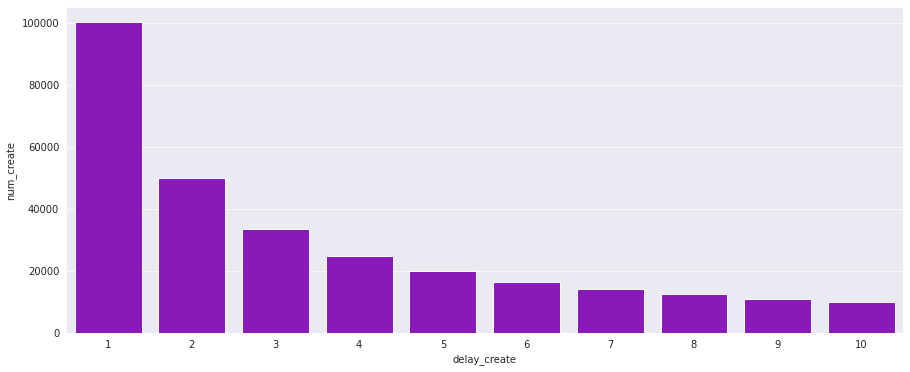

In [73]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.barplot(x='delay_create', y='num_create', data=df, ax=ax, color='darkviolet')

ax.set_xlabel(u'delay_create')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'num_create')
ax.set_title(u'');

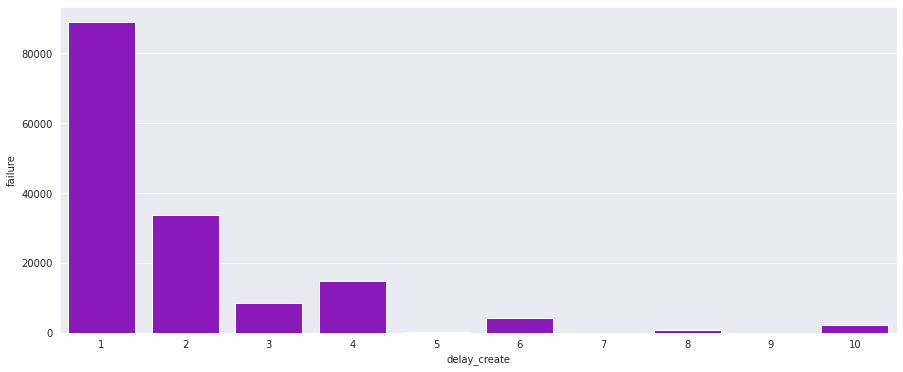

In [74]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.barplot(x='delay_create', y='failure', data=df, ax=ax, color='darkviolet')

ax.set_xlabel(u'delay_create')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'failure')
ax.set_title(u'');

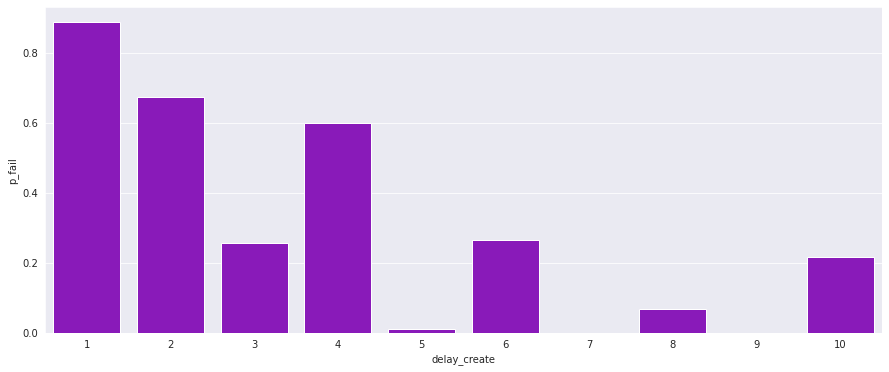

In [75]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.barplot(x='delay_create', y='p_fail', data=df, ax=ax, color='darkviolet')

ax.set_xlabel(u'delay_create')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'p_fail')
ax.set_title(u'');

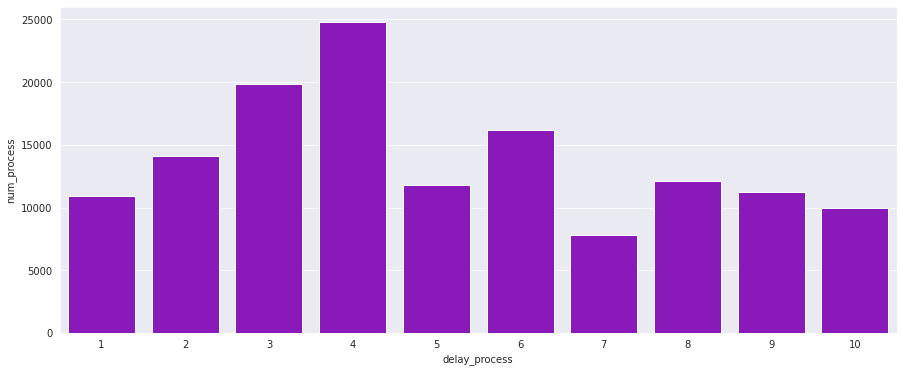

In [76]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.barplot(x='delay_process', y='num_process', data=df, ax=ax, color='darkviolet')

ax.set_xlabel(u'delay_process')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'num_process')
ax.set_title(u'');

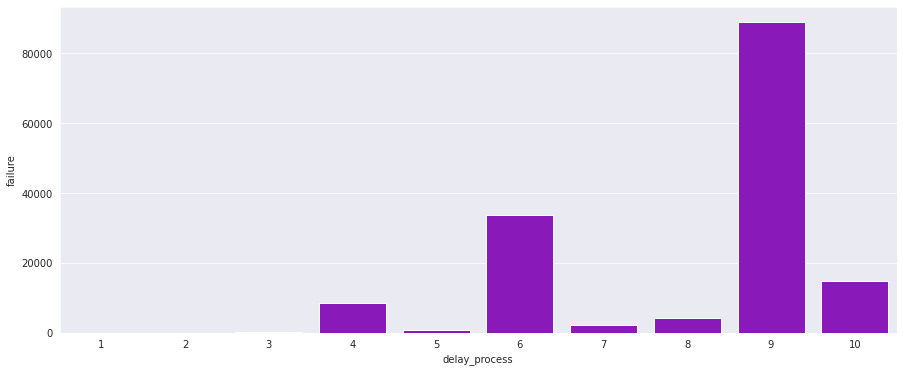

In [77]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.barplot(x='delay_process', y='failure', data=df, ax=ax, color='darkviolet')

ax.set_xlabel(u'delay_process')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'failure')
ax.set_title(u'');

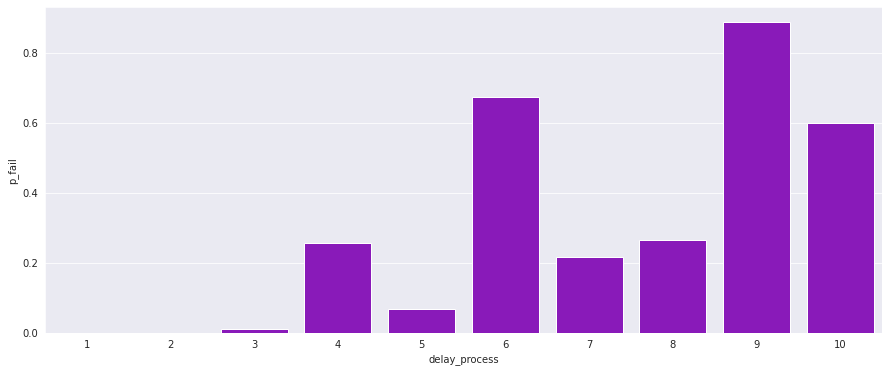

In [78]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.barplot(x='delay_process', y='p_fail', data=df, ax=ax, color='darkviolet')

ax.set_xlabel(u'delay_process')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'p_fail')
ax.set_title(u'');